In [15]:
import tinygrad as tg
from tinygrad.tensor import Tensor
import numpy as np
from typing import Callable
import matplotlib
import matplotlib.pyplot as plt
# Do not pick MacOsx because it will crash the jupyter kernel 
#matplotlib.use('nbAgg')  # Replace 'TkAgg' with your preferred backend

# The goal is to express all polynomials with a neural network that only uses relu activation functions
# many thanks to Nikolaj-K @ https://www.youtube.com/watch?v=PApGm1TKFHQ for the topic
# rewrote it in a different way

# Utils


In [42]:
def plot(x: np.ndarray) -> Callable[[np.ndarray,str,str], None]:
    """
    Curries X into the plot function
    """
    def fn(y: np.ndarray, label: str, color: str) -> None:
        plt.plot(x, y, label=label, color=color)
    return lambda y,label,color : fn(y,label,color)


def plt_setup(xlim:tuple = (0,1), ylim:tuple = (0,1), title:str = "getting $a*(X^2)+b$ from Relus is the goal") -> None:
    plt.grid(True)
    plt.style.use('dark_background')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.style.use('dark_background')
    return None

color_cycle = matplotlib.colormaps["Spectral"]


# STEP 1 : get X^2 from adding piecewise linear functions (triangle wave functions)

In [17]:
def triangle_wave(x: tg.Tensor) -> tg.Tensor:
    """ 
    we call this $S_n(x)$ below
    """
    left = x-x.floor()
    right = x.ceil()-x
    return (left<right)*left +(left>=right)*right

def takagi(x: tg.Tensor, N:int) ->  tg.Tensor:
    #https://en.wikipedia.org/wiki/Blancmange_curve
    return tg.Tensor.stack([takagi_piece(x,i) for i in range(N)],dim=1).sum(axis=1)

def takagi_piece(x: tg.Tensor, i: int) -> tg.Tensor:
    w = 0.25 # w=1/4 gives the parabola !
    return (w**i) * triangle_wave((2**i)*x)

Text(0.5, 1.0, 'takagi pieces')

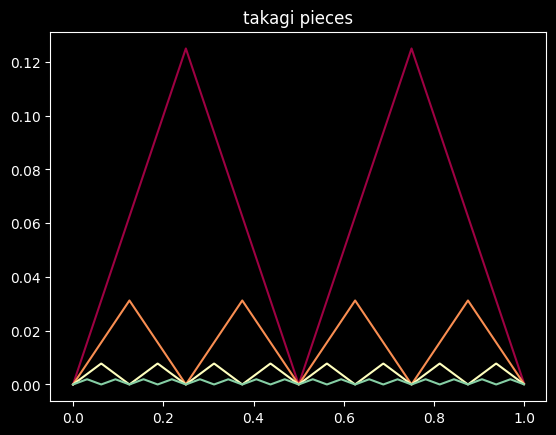

In [76]:
# Let's print the takagi pieces once by one and see what they look like
X=tg.Tensor.arange(0,1,0.001)
prt(takagi_piece(X,1).numpy(), "takagi_piece(X,1)", color=color_cycle(0.0))
prt(takagi_piece(X,2).numpy(), "takagi_piece(X,2)", color=color_cycle(0.25))
prt(takagi_piece(X,3).numpy(), "takagi_piece(X,3)", color=color_cycle(0.5))
prt(takagi_piece(X,4).numpy(), "takagi_piece(X,4)", color=color_cycle(0.75))

plt.title("takagi pieces")

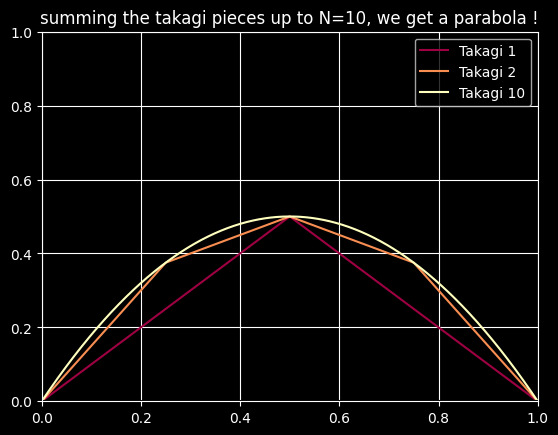

In [79]:
X=tg.Tensor.arange(0,1,0.001)
prt = plot(X.numpy())
prt(takagi(X,1).numpy(), "Takagi 1", color=color_cycle(0.0))
prt(takagi(X,2).numpy(), "Takagi 2", color=color_cycle(0.25))
prt(takagi(X,10).numpy(), "Takagi 10", color=color_cycle(0.5))
plt_setup(title="summing the takagi pieces up to N=10, we get a parabola !")
plt.legend(loc='best')
plt.show()

# Step 2 : get the triangle wave functions from Relus

Now we will try to recreate this but only with linear combinations of Relus and shifted relus (essentially a neural network with 1 input x, Relus as the activation function) 

In [6]:
# MOVEMENT OPERATIONS ON FUNCTIONS OF TENSOR TO TENSOR

def shift(d:float, f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Shifts a function by d
    towards the right if d>0
    """
    return lambda x: f(x-d)

def mul(a:float, f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Multiplies a function by a
    """
    return lambda x: a*f(x)

def add(f: Callable[[tg.Tensor], tg.Tensor], g: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Adds two functions
    """
    return lambda x: f(x)+g(x)

def minus(f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Flips a function along the x axis
    """
    return lambda x: -f(x)

# BASIC FUNCTIONS

def relu(x: Tensor) -> Tensor:
    return x.relu()

def anti_relu(lmd:float,d:float) : 
    # this destroys the previous relus with 
    # a new one that is shifted by d and scaled by lmd=lambda
    return mul(-lmd,shift(d,relu))

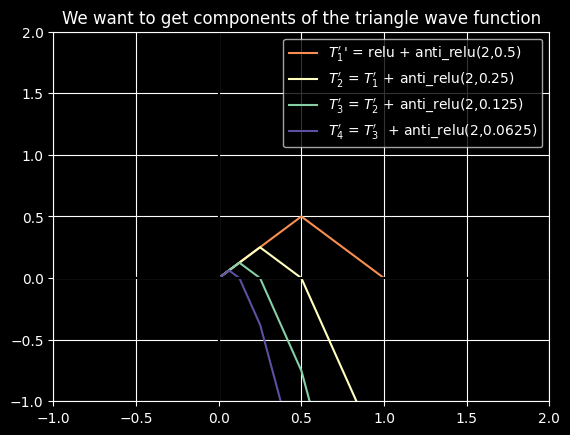

In [64]:
X = Tensor.arange(0,1,0.001)

# X.numpy() = relu(X).numpy()) # relu : the starting point

# We cut in half the frist relu and create a triangle
T_1_prime = add(relu,anti_relu(2,0.5))

prt(T_1_prime(X).numpy(), "$T_1^{\prime}$' = relu + anti_relu(2,0.5)", color=color_cycle(0.25))

T_2_prime = add(T_1_prime,anti_relu(2,0.25))

prt(T_2_prime(X).numpy(), "$T_2^{\prime}$ = $T_1^{\prime}$ + anti_relu(2,0.25)", color=color_cycle(0.5))

T_3_prime = add(T_2_prime,anti_relu(2,0.125))

prt(T_3_prime(X).numpy(), "$T_3^{\prime}$ = $T_2^{\prime}$ + anti_relu(2,0.125)", color=color_cycle(0.75))

T_4_prime = add(T_3_prime,anti_relu(2,0.0625))

prt(T_4_prime(X).numpy(), "$T_4^{\prime}$ = $T_3^{\prime}$  + anti_relu(2,0.0625)", color=color_cycle(1.0))

plt_setup(xlim=(-1,2), ylim=(-1,2), title="We want to get components of the triangle wave function" )
plt.legend(loc='best')
plt.show()

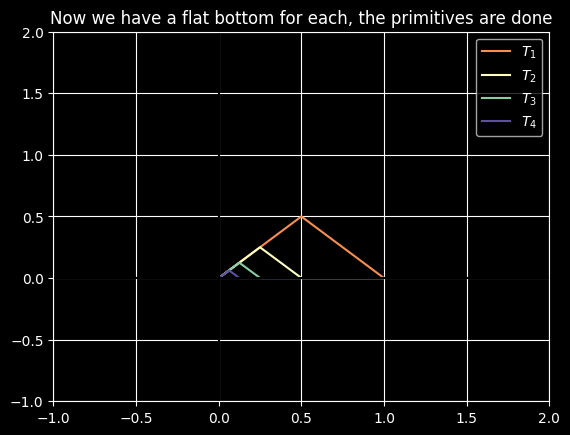

In [65]:
# Now correct make the slope after we hit 0 to be 0 for all curves so we can compose them to get all triangle wave functions


X = Tensor.arange(0,1,0.001)

# X.numpy() = relu(X).numpy()) # relu : the starting point

# We cut in half the frist relu and create a triangle
T_1 = add(relu,anti_relu(2,0.5))

prt(T_1(X).numpy(), "$T_1$", color=color_cycle(0.25))

T_2 = add(add(T_1,anti_relu(2,0.25)),mul(3,shift(0.5,relu)))

prt(T_2(X).numpy(), "$T_2$", color=color_cycle(0.5))

T_3 = add(add(add(T_2,anti_relu(2,0.125)),mul(3,shift(0.25,relu))),mul(-1,shift(0.5,relu)))

prt(T_3(X).numpy(), "$T_3$", color=color_cycle(0.75))

T_4 = add(add(add(T_3,anti_relu(2,0.0625)),mul(3,shift(0.125,relu))),mul(-1,shift(0.25,relu)))

prt(T_4(X).numpy(), "$T_4$", color=color_cycle(1.0))

plt_setup(xlim=(-1,2), ylim=(-1,2), title="Now we have a flat bottom for each, the primitives are done" )
plt.legend(loc='best')
plt.show()



Now we have a primitive for the triangle wave function at every scale in the interval [0,1]

The general formula to obtain $T_n$ the nth primitive is : 

$T_{n} = T_{n-1} - 2R(x-(1/2)^{n+2}) + 3R(x-(1/2)^{n+1}) -R(x-(1/2)^n)$


We call $S_n : x \in [0,1] \to S_n(x) \in [0,1/2]$ the triangle wave function that has $n$ peaks on [0,1]

Now we will create $S_n$ by adding the primitives shifted together

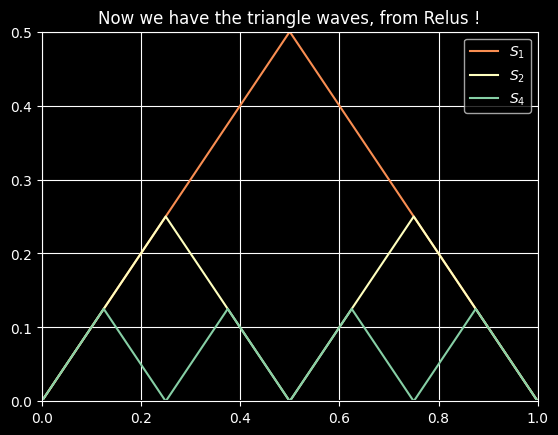

In [86]:
X = Tensor.arange(0,1,0.001)

# X.numpy() = relu(X).numpy()) # relu : the starting point

# We cut in half the frist relu and create a triangle
S_1 = T_1

prt(S_1(X).numpy(), "$S_1$", color=color_cycle(0.25))

S_2 = add(T_2,shift(0.5, T_2)) #add(T_2,shift(0.5, T_2))

prt(S_2(X).numpy(), "$S_2$", color=color_cycle(0.5))

S_3 = add(add(add(T_3,shift(0.25, T_3)),shift(0.5, T_3)),shift(0.75, T_3))

prt(S_3(X).numpy(), "$S_4$", color=color_cycle(0.75))


T_4 = add(T_3,anti_relu(2,0.0625))

# prt(T_4(X).numpy(), "$T_4^{\prime}$ = $T_3^{\prime}$  + anti_relu(2,0.0625)", color=color_cycle(1.0))

plt_setup(xlim=(0,1), ylim=(0,1/2), title="Now we have the triangle waves, from Relus !" )
plt.legend(loc='best')
plt.show()

In [ ]:
# Now we just need to scale them 


